<a href="https://colab.research.google.com/github/sreent/machine-learning/blob/main/Linear%20Regression/Linear%20Regression%20Stock%20Price%20Prediction%20Case%20Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case Study: Stock Price Prediction with Linear Regression

## The Challenge: Building a Unified Model Across Different Stocks

**Business Problem:**  
We want to predict stock prices **4 weeks ahead** for FTSE 100 companies using historical data. However, we face a critical challenge:

- **Stock AAF.L** trades around **68 pence (£0.68)**
- **Stock WTB.L** trades around **3,000 pence (£30.00)**

*Note: FTSE 100 prices are quoted in GBX (pence), not GBP (pounds)*

**Why is this a problem?**

If we naively use raw prices as both features and targets:
- A 5p prediction error on AAF.L (68p) = **7.4% error** 😱
- A 5p prediction error on WTB.L (3,000p) = **0.17% error** ✅

The model would optimize for expensive stocks and perform terribly on cheaper ones!

**The Solution: Think Like a Quant Trader**

Professional traders don't care about absolute price movements - they care about **percentage returns**:

$$\text{Return} = \frac{\text{Price}_{today} - \text{Price}_{yesterday}}{\text{Price}_{yesterday}}$$

- A **5% gain** is meaningful whether on a 68p or 3,000p stock
- Returns are **scale-invariant** - perfect for a unified model!
- Returns are **additive** over time (log returns)

**What We'll Build:**
1. Load ~580K rows of FTSE 100 daily OHLC data (2019-2025)
2. Engineer financial features: returns, volatility, momentum, moving averages
3. Create lagged features (past returns predict future returns)
4. Handle time-series data properly (no future data leakage!)
5. Build a unified linear regression model predicting **4-week returns**
6. Evaluate performance and understand limitations

## Learning Objectives

By the end of this case study, you will:

✅ Understand why **returns** (not prices) are used in financial ML  
✅ Learn proper **time-series cross-validation** to avoid lookahead bias  
✅ Engineer **domain-specific features** for stock prediction  
✅ Handle **multiple entities** (100 stocks) in a unified model  
✅ Interpret model performance in financial context  
✅ Understand the **challenges and limitations** of linear models for finance

---

## 🚀 TL;DR - The 4-Step Pipeline

If you're already familiar with ML, here's the quick overview:

```
┌─────────────────────────────────────────────────────────────────┐
│ 1. DATA TRANSFORMATION: Prices → Percentage Returns             │
│    Why: 68p stock ≠ 3,000p stock, but 5% return = 5% return     │
└─────────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────────┐
│ 2. FEATURE ENGINEERING: Lags (1/5/10/20d) + Volatility + MA     │
│    Critical: Sort by [ticker, date] before ANY calculations!    │
└─────────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────────┐
│ 3. TIME-SERIES SPLIT: Train (2019-2023) → Val (2024) → Test     │
│    Never random split! Would leak future into past              │
└─────────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────────┐
│ 4. EVALUATION: Multiple Metrics (Both Matter!)                  │
│    • R² measures accuracy of predicted magnitudes               │
│    • Hit Rate measures directional correctness (UP vs DOWN)     │
│    For trading: 55% Hit Rate can be profitable even if R² low   │
└─────────────────────────────────────────────────────────────────┘
```

**Key Results to Expect:**
- R²: ~0.01-0.05 (low is normal for finance!)
- Hit Rate: 51-55% (slight edge over 50% random)
- Learning: Domain knowledge matters more than algorithm complexity

Now let's dive into the details! 👇

## Step 1: Import Libraries and Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# ============================================================================
# CONFIGURATION: Prediction Horizon
# ============================================================================
# Set the prediction horizon (how many trading days ahead to predict)
# Common choices:
#   - 5 days  = 1 week
#   - 10 days = 2 weeks
#   - 20 days = 4 weeks (default)

PREDICTION_HORIZON = 20  # Trading days (4 weeks)

# Calculate human-readable description
horizon_weeks = PREDICTION_HORIZON / 5
if horizon_weeks == 1:
    HORIZON_NAME = "1-week"
elif horizon_weeks == 2:
    HORIZON_NAME = "2-week"
elif horizon_weeks == 4:
    HORIZON_NAME = "4-week"
else:
    HORIZON_NAME = f"{PREDICTION_HORIZON}-day"

print(f"📊 Prediction Horizon: {PREDICTION_HORIZON} trading days ({HORIZON_NAME})")
print(f"   We will predict returns {HORIZON_NAME} into the future.")

In [16]:
# Load the FTSE 100 dataset directly from Google Drive
file_id = '14eS3EEKXmDFy-tMXAjqzF8jT6SwZWTJD'
url = f'https://drive.google.com/uc?export=download&id={file_id}'
df = pd.read_csv(url, parse_dates=['date'])
df = df[(df["ticker"]!="NXT.L") & (df["date"]>="2021-01-01")]

print(f"Dataset shape: {df.shape}")
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")
print(f"Number of unique tickers: {df['ticker'].nunique()}")
print(f"\nFirst few rows:")
df.head(10)

Dataset shape: (115634, 8)

Date range: 2021-01-04 00:00:00 to 2025-08-29 00:00:00
Number of unique tickers: 99

First few rows:


,date,ticker,open,high,low,close,adjclose,volume
384,2021-01-04,AAF.L,77.6,78.2,74.40,74.4,63.01,1496738
385,2021-01-05,AAF.L,76.6,77.6,74.40,77.6,65.72,2198045
386,2021-01-06,AAF.L,78.5,80.3,76.60,80.3,68.00,3017284
387,2021-01-07,AAF.L,82.5,82.5,79.40,79.7,67.49,1473496
388,2021-01-08,AAF.L,83.4,83.4,77.86,78.2,66.22,1579485
389,2021-01-11,AAF.L,79.7,79.8,76.30,77.6,65.72,940470
390,2021-01-12,AAF.L,79.0,79.7,76.40,76.4,64.70,773573
391,2021-01-13,AAF.L,77.0,78.0,75.50,75.5,63.94,5943326
392,2021-01-14,AAF.L,78.0,80.5,75.40,80.5,68.17,1563365
393,2021-01-15,AAF.L,82.9,82.9,76.90,78.7,66.65,1291394


In [17]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())
print(f"\nBasic statistics:")
df.describe()

Missing values per column:
date        0
ticker      0
open        0
high        0
low         0
close       0
adjclose    0
volume      0
dtype: int64

Basic statistics:


,date,open,high,low,close,adjclose,volume
count,115634,115634.0000,115634.0000,115634.0000,115634.0000,115634.0000,1.1563e+05
mean,2023-05-03 11:46:50.972551424,1881.2937,1901.4713,1860.4459,1880.9400,1752.2236,8.8609e+06
min,2021-01-04 00:00:00,32.8400,33.5400,6.0800,33.0000,26.1900,6.1000e+01
25%,2022-03-04 00:00:00,444.4000,449.6625,439.1000,444.4625,396.4300,8.2403e+05
50%,2023-05-05 00:00:00,1020.0000,1030.0000,1008.5000,1019.5000,960.7700,2.2206e+06
75%,2024-07-02 00:00:00,2465.8900,2493.0000,2441.0000,2465.0000,2274.0450,6.3397e+06
max,2025-08-29 00:00:00,17105.0000,17225.0000,16895.0000,17135.0000,16561.9900,8.8893e+08
std,NaN,2293.0472,2316.8794,2267.5727,2292.4191,2170.4530,2.4367e+07


## Step 2: Exploratory Data Analysis - The Price Scale Problem

Price statistics by ticker (sorted by mean price):

Cheapest stocks:
          min      mean     max      std
ticker                                  
LLOY.L  26.19   45.2860   84.10  12.1707
VOD.L   56.81   77.5996  105.65  12.5384
CNA.L   41.50  100.8449  168.35  37.5408
AAF.L   60.47  112.2221  223.20  29.8911
TW.L    66.63  113.6452  159.21  18.2052

Most expensive stocks:
            min       mean       max        std
ticker                                         
IHG.L   3947.61  6121.8085  10715.99  1831.7117
LSEG.L  6044.96  8463.3281  11938.62  1485.6954
GAW.L   5043.99  9588.9235  16561.99  2684.4088
SPX.L   5338.37  9892.0495  16041.96  2411.1973
AZN.L   6350.13  9968.8169  12994.64  1539.7414


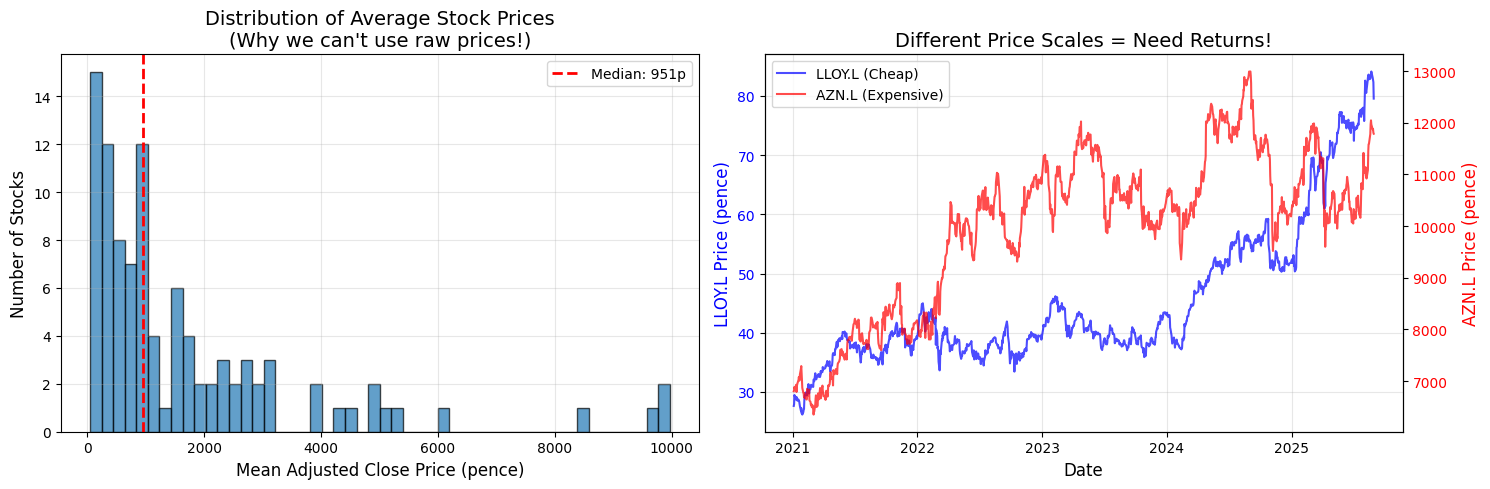


💡 Key Insight: Prices range from 45p to 9969p
   (£0.45 to £99.69)
   This 220x difference makes raw prices unusable!


In [18]:
# Analyze price ranges across different stocks
price_stats = df.groupby('ticker')['adjclose'].agg(['min', 'mean', 'max', 'std']).sort_values('mean')

print("Price statistics by ticker (sorted by mean price):")
print("\nCheapest stocks:")
print(price_stats.head(5))
print("\nMost expensive stocks:")
print(price_stats.tail(5))

# Visualize the problem
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Price range distribution
axes[0].hist(price_stats['mean'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Mean Adjusted Close Price (pence)', fontsize=12)
axes[0].set_ylabel('Number of Stocks', fontsize=12)
axes[0].set_title('Distribution of Average Stock Prices\n(Why we can\'t use raw prices!)', fontsize=14)
axes[0].axvline(price_stats['mean'].median(), color='red', linestyle='--',
               linewidth=2, label=f'Median: {price_stats["mean"].median():.0f}p')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Example time series for cheap vs expensive stocks
cheap_stock = price_stats.index[0]  # Cheapest
expensive_stock = price_stats.index[-1]  # Most expensive

cheap_data = df[df['ticker'] == cheap_stock].set_index('date')['adjclose']
expensive_data = df[df['ticker'] == expensive_stock].set_index('date')['adjclose']

ax2 = axes[1]
ax2_twin = ax2.twinx()

ax2.plot(cheap_data.index, cheap_data.values, 'b-', linewidth=1.5, label=f'{cheap_stock} (Cheap)', alpha=0.7)
ax2_twin.plot(expensive_data.index, expensive_data.values, 'r-', linewidth=1.5, label=f'{expensive_stock} (Expensive)', alpha=0.7)

ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel(f'{cheap_stock} Price (pence)', color='b', fontsize=12)
ax2_twin.set_ylabel(f'{expensive_stock} Price (pence)', color='r', fontsize=12)
ax2.set_title('Different Price Scales = Need Returns!', fontsize=14)
ax2.tick_params(axis='y', labelcolor='b')
ax2_twin.tick_params(axis='y', labelcolor='r')
ax2.grid(True, alpha=0.3)

# Combine legends
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

print(f"\n💡 Key Insight: Prices range from {price_stats['mean'].min():.0f}p to {price_stats['mean'].max():.0f}p")
print(f"   (£{price_stats['mean'].min()/100:.2f} to £{price_stats['mean'].max()/100:.2f})")
print(f"   This {price_stats['mean'].max() / price_stats['mean'].min():.0f}x difference makes raw prices unusable!")

> **Question**: You're building a unified model for FTSE 100 stocks where prices range from 68p to 3,000p. Why is using percentage returns essential instead of raw prices?
>
> A. Returns ensure all features scale to [0,1] range, which improves gradient descent convergence rates
>
> B. Returns make movements comparable: 5p is 7.4% for 68p stocks vs 0.17% for 3,000p stocks
>
> C. Linear regression's normal equation requires all features to use identical measurement units
>
> D. Returns reduce overfitting by normalizing the target variable to have zero mean

<details><summary>Click to reveal answer</summary>

**Correct Answer: B**

**Explanation:**
- **B is TRUE**: Raw prices have different meanings across stocks. A 5p error on a 68p stock is a massive 7.4% mistake, while the same 5p error on a 3,000p stock is only 0.17%. The model would optimize for expensive stocks (where absolute errors are small percentages) and ignore cheap stocks (where absolute errors are huge percentages). Returns put everything on the same scale: a 5% gain means the same thing for all stocks.

- **A is FALSE**: Returns don't scale to [0,1] - they can be negative (stock goes down) and can exceed 100% in theory. That's min-max scaling, not percentage returns. Also, we're using the normal equation (closed-form solution), not gradient descent, so convergence isn't relevant here.

- **C is FALSE**: Linear regression works fine with mixed units mathematically - the normal equation w = (ΦᵀΦ)⁻¹Φᵀy computes regardless of units. The issue is MODEL QUALITY and INTERPRETABILITY, not mathematical requirements.

- **D is FALSE**: While returns do tend to be centered around zero, this isn't about overfitting prevention. Overfitting is controlled through regularization, feature selection, and validation. The key issue is comparability across stocks with different price scales.

**Key Insight**: For multi-entity models, use **relative measures** (percentages, ratios) not **absolute measures** (raw values) to ensure fair comparison across all entities!

</details>

## Step 3: Feature Engineering - The Solution

### Step 3a: Understanding the Approach (Concept)

### Feature Engineering Design Principles

**CRITICAL: Sorting Before Feature Calculation**

Before calculating ANY time-series features, we **MUST** sort by `['ticker', 'date']`:

```python
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)
grouped = df.groupby('ticker')
```

**Why is this absolutely critical?**

❌ **Without proper sorting, disasters happen:**

1. **Wrong lag values**: `shift(1)` gives you a random previous row, not yesterday!
   - Example: If data is unsorted, "yesterday's return" might actually be from 6 months ago or a different stock
   
2. **Mixed ticker data**: Rolling windows could include multiple stocks!
   - Example: 5-day volatility for AAF.L accidentally includes days from WTB.L
   
3. **Time travel paradoxes**: Future data leaks into past features
   - Example: "Yesterday's" return is actually from next month

4. **Incorrect momentum**: Cumulative returns calculated across time gaps
   - Example: 5-day return spans from Monday to Friday 2 years later

**Correct approach:**
```python
# Step 1: Sort by ticker AND date
df.sort_values(['ticker', 'date'])  # Ensures each ticker's data is chronological

# Step 2: Group by ticker before ANY time-series operations
grouped = df.groupby('ticker')

# Step 3: Use grouped transforms (automatically respects ticker boundaries)
grouped['adjclose'].transform(lambda x: x.shift(1))  # Safe! Won't mix tickers
```

**Visual example of the problem:**

| Before Sorting (WRONG) | After Sorting (CORRECT) |
|------------------------|-------------------------|
| 2024-01-05, WTB.L, 3000p | 2024-01-01, AAF.L, 68p |
| 2024-01-01, AAF.L, 68p   | 2024-01-02, AAF.L, 70p |
| 2024-01-03, WTB.L, 3020p | 2024-01-03, AAF.L, 69p |
| 2024-01-02, AAF.L, 70p   | 2024-01-01, WTB.L, 3000p |
| 2024-01-03, AAF.L, 69p   | 2024-01-03, WTB.L, 3020p |
|                          | 2024-01-05, WTB.L, 3010p |

Without sorting, `shift(1)` on row 2 gives you WTB.L's price (3000p) as AAF.L's "previous day"! 💥

**Why Percentage-Based Features?**

For a unified model across stocks with vastly different prices (68p vs 3,000p), we need features that are **comparable** across tickers:

1. **Returns** (not prices):
   - A 5p move on AAF.L (68p) = 7.4% change
   - A 5p move on WTB.L (3,000p) = 0.17% change
   - Solution: Use percentage returns so both are on the same scale

2. **Lagged Returns at Meaningful Intervals**:
   - Not arbitrary (1,2,3,4,5 days) but trading-relevant periods
   - **1 day**: Yesterday's performance
   - **5 days**: 1 week ago (captures weekly patterns)
   - **10 days**: 2 weeks ago (medium-term trends)
   - **20 days**: 4 weeks ago (matches our prediction horizon)

3. **Volatility as Percentage**:
   - Standard deviation of returns (already in percentage terms)
   - 2% daily volatility means the same thing for all stocks

4. **Momentum as Percentage Change**:
   - (Price_t / Price_t-k) - 1 gives percentage gain/loss
   - +10% momentum is comparable whether on 68p or 3,000p stock

5. **Moving Averages Normalized**:
   - Distance from MA as percentage of current price
   - (Price - MA) / Price shows relative deviation
   - Being 5% above MA means the same thing for all tickers

6. **Target: 4-Week Percentage Change**:
   - (Price_t+20 - Price_t) / Price_t
   - Predicting percentage returns (not absolute price changes)

**Why Use Adjusted Close?**

We use `adjclose` (adjusted close) instead of `close` because:
- **Stock splits**: A 2-for-1 split halves the raw close price overnight. Adjusted close adjusts all historical prices so returns remain accurate.
- **Dividends**: When a stock pays dividends, the price drops by approximately that amount. Adjusted close factors this in for total return.
- **Accurate backtesting**: Using raw close prices gives misleading historical returns. Adjusted close gives true investment returns.

**Mathematical Note: Log Returns vs Simple Returns**

For small changes (<10%), log return ≈ simple percentage return:
- Simple return: (P_t - P_t-1) / P_t-1 = 0.05 means +5%
- Log return: ln(P_t / P_t-1) = 0.0488 ≈ 5%

For consistency and because our daily returns are typically < 5%, we use log returns for features but simple percentage returns for momentum (cumulative) calculations.

> **Question**: Your model achieves 85% training R² but only 8% validation R² on stock returns. You discover you forgot to sort by ['ticker', 'date'] before calculating lagged features. What likely happened?
>
> A. Features mixed data across stocks and time periods, causing severe data leakage and overfitting
>
> B. Pandas groupby operations failed silently, producing NaN values that corrupted your training process
>
> C. The model trained slower due to cache misses, but predictions remain mathematically identical
>
> D. Only the first ticker's features are corrupted; other tickers processed correctly sequentially

<details><summary>Click to reveal answer</summary>

**Correct Answer: A**

**Explanation:**
- **A is TRUE**: Without sorting, shift(1) gives you the previous ROW, not the previous DAY. Features like "yesterday's return" could actually be from 6 months in the future or from a completely different stock. This creates massive data leakage - your model is "learning" from randomly mixed future/past data and different stocks, which explains the 85% training R² (it's memorizing corrupted patterns). But on properly ordered validation data, these patterns don't exist, causing the collapse to 8%.

- **B is FALSE**: Pandas groupby doesn't require pre-sorted data and won't fail silently. It will compute the operations, just with wrong results because the temporal order is scrambled. You'd get numerical values, not NaN errors.

- **C is FALSE**: The predictions are fundamentally WRONG, not just slower. Your "lag_1d" feature contains random data from the wrong time periods and wrong stocks. This isn't a performance issue - it's a correctness catastrophe.

- **D is FALSE**: ALL tickers are affected equally. There's no mechanism where the first ticker suffers while others are fine. Each ticker's time series is scrambled if you don't sort properly first.

**Key Insight**: For time-series features, **sort by [entity, time] BEFORE any shift/rolling operations** - this isn't optional, it's mandatory for correctness!

</details>

In [19]:
def engineer_features(df):
    """
    Engineer financial features from OHLC data.
    All features are percentage-based and scale-invariant for comparing across tickers!

    Important: Uses 'adjclose' (adjusted close) instead of 'close' to account for
    stock splits and dividends, ensuring accurate historical returns.

    Key Design Principles:
    - Use meaningful lag intervals: 1, 5, 10, 20 trading days (1 day, 1 week, 2 weeks, 4 weeks)
    - All features in percentage terms for apple-to-apple comparison
    - Volatility, momentum, and moving averages normalized by price
    """
    # ⚠️ CRITICAL: Sort by ticker and date to ensure proper time series order
    df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

    # Group by ticker for time-series operations
    grouped = df.groupby('ticker')

    # ========================================
    # 1. DAILY RETURN (base feature)
    # ========================================
    # Daily percentage return (log return ≈ percentage for small changes)
    df['return_1d'] = grouped['adjclose'].transform(lambda x: np.log(x / x.shift(1)))

    # ========================================
    # 2. LAGGED RETURNS (past performance at key intervals)
    # ========================================
    # Meaningful trading intervals: 1 day, 1 week, 2 weeks, 4 weeks
    df['return_lag_1d'] = grouped['return_1d'].shift(1)      # Yesterday
    df['return_lag_5d'] = grouped['return_1d'].shift(5)      # 1 week ago
    df['return_lag_10d'] = grouped['return_1d'].shift(10)    # 2 weeks ago
    df['return_lag_20d'] = grouped['return_1d'].shift(20)    # 4 weeks ago

    # Cumulative returns over these periods (percentage change)
    df['return_cum_5d'] = grouped['adjclose'].transform(lambda x: (x / x.shift(5)) - 1)   # 1-week return
    df['return_cum_10d'] = grouped['adjclose'].transform(lambda x: (x / x.shift(10)) - 1) # 2-week return
    df['return_cum_20d'] = grouped['adjclose'].transform(lambda x: (x / x.shift(20)) - 1) # 4-week return

    # ========================================
    # 3. VOLATILITY (risk measure in percentage)
    # ========================================
    # 5-day rolling standard deviation of returns (already in percentage terms)
    df['volatility_5d'] = grouped['return_1d'].transform(lambda x: x.shift(1).rolling(5).std())

    # 20-day rolling volatility (monthly volatility)
    df['volatility_20d'] = grouped['return_1d'].transform(lambda x: x.shift(1).rolling(20).std())

    # Intraday range as percentage of adjusted close (high-low spread)
    df['range_hl_pct'] = (df['high'] - df['low']) / df['adjclose']

    # ========================================
    # 4. MOMENTUM INDICATORS (percentage-based)
    # ========================================
    # Already calculated above as return_cum_5d, return_cum_10d, return_cum_20d
    # These represent momentum: positive = upward trend, negative = downward trend

    # ========================================
    # 5. MOVING AVERAGES (trend indicators in percentage)
    # ========================================
    # Distance from 5-day MA (short-term trend)
    df['ma_5d'] = grouped['adjclose'].transform(lambda x: x.rolling(5).mean())
    df['dist_from_ma5_pct'] = (df['adjclose'] - df['ma_5d']) / df['adjclose']

    # Distance from 20-day MA (medium-term trend)
    df['ma_20d'] = grouped['adjclose'].transform(lambda x: x.rolling(20).mean())
    df['dist_from_ma20_pct'] = (df['adjclose'] - df['ma_20d']) / df['adjclose']

    # ========================================
    # 6. INTRADAY BEHAVIOR (percentage-based)
    # ========================================
    # Intraday return (open to adjusted close) as percentage
    df['return_intraday'] = (df['adjclose'] - df['open']) / df['open']

    # Overnight return (previous adjusted close to today's open) as percentage
    df['return_overnight'] = grouped.apply(
        lambda x: (x['open'] - x['adjclose'].shift(1)) / x['adjclose'].shift(1)
    ).reset_index(level=0, drop=True)

    # ========================================
    # 7. TARGET: 4-WEEK FUTURE RETURN (percentage change)
    # ========================================
    # This is what we want to predict!
    # Percentage change PREDICTION_HORIZON trading days (HORIZON_NAME) into the future
    df[f'target_return_{HORIZON_NAME}'] = grouped['adjclose'].transform(lambda x: (x.shift(-PREDICTION_HORIZON) - x) / x)

    return df

print("Engineering features...")
df_features = engineer_features(df.copy())
print(f"✅ Created {len(df_features.columns) - len(df.columns)} new features")
print(f"\nNew columns: {list(df_features.columns[len(df.columns):])}")

Engineering features...
✅ Created 18 new features

New columns: ['return_1d', 'return_lag_1d', 'return_lag_5d', 'return_lag_10d', 'return_lag_20d', 'return_cum_5d', 'return_cum_10d', 'return_cum_20d', 'volatility_5d', 'volatility_20d', 'range_hl_pct', 'ma_5d', 'dist_from_ma5_pct', 'ma_20d', 'dist_from_ma20_pct', 'return_intraday', 'return_overnight', 'target_return_4w']


In [20]:
# Inspect the engineered features
print("Sample of engineered features:")
display_cols = ['date', 'ticker', 'adjclose', 'return_1d', 'return_lag_1d', 'return_lag_5d',
                'return_cum_5d', 'volatility_5d', 'dist_from_ma20_pct', 'target_return_4w']
df_features[display_cols].head(30)

Sample of engineered features:


,date,ticker,adjclose,return_1d,return_lag_1d,return_lag_5d,return_cum_5d,volatility_5d,dist_from_ma20_pct,target_return_4w
0,2021-01-04,AAF.L,63.01,NaN,NaN,NaN,NaN,NaN,NaN,0.1062
1,2021-01-05,AAF.L,65.72,0.0421,NaN,NaN,NaN,NaN,NaN,0.0528
2,2021-01-06,AAF.L,68.00,0.0341,0.0421,NaN,NaN,NaN,NaN,0.0337
3,2021-01-07,AAF.L,67.49,-0.0075,0.0341,NaN,NaN,NaN,NaN,0.0227
4,2021-01-08,AAF.L,66.22,-0.0190,-0.0075,NaN,NaN,NaN,NaN,0.0103
5,2021-01-11,AAF.L,65.72,-0.0076,-0.0190,NaN,0.0430,NaN,NaN,0.0309
6,2021-01-12,AAF.L,64.70,-0.0156,-0.0076,0.0421,-0.0155,0.0276,NaN,0.0117
7,2021-01-13,AAF.L,63.94,-0.0118,-0.0156,0.0341,-0.0597,0.0214,NaN,0.0410
8,2021-01-14,AAF.L,68.17,0.0641,-0.0118,-0.0075,0.0101,0.0050,NaN,-0.0348
9,2021-01-15,AAF.L,66.65,-0.0225,0.0641,-0.0190,0.0065,0.0350,NaN,-0.0089


## Step 4: Visualize Returns vs Prices

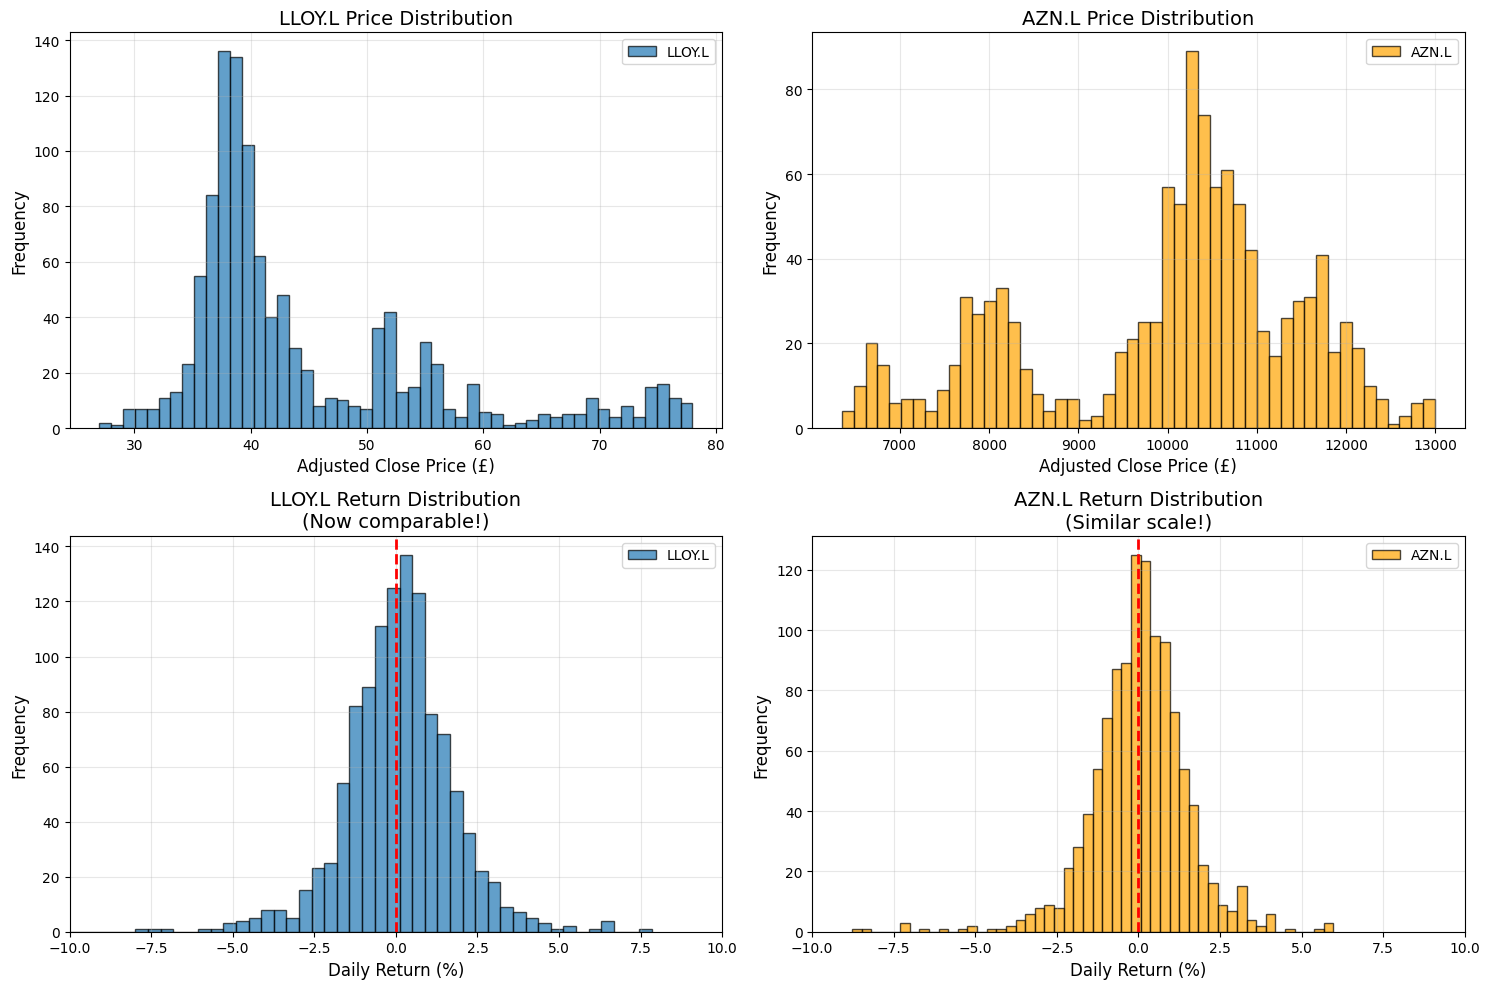


💡 Key Insight: Returns put both stocks on the SAME scale!
   LLOY.L return std: 1.70%
   AZN.L return std: 1.48%
   These are comparable, unlike prices!


In [21]:
# Compare distributions: prices vs returns
# Pick two stocks with very different price levels
cheap_ticker = price_stats.index[0]
expensive_ticker = price_stats.index[-1]

cheap_df = df_features[df_features['ticker'] == cheap_ticker].dropna()
expensive_df = df_features[df_features['ticker'] == expensive_ticker].dropna()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Row 1: Prices
axes[0, 0].hist(cheap_df['adjclose'], bins=50, alpha=0.7, edgecolor='black', label=cheap_ticker)
axes[0, 0].set_xlabel('Adjusted Close Price (£)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title(f'{cheap_ticker} Price Distribution', fontsize=14)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(expensive_df['adjclose'], bins=50, alpha=0.7, color='orange', edgecolor='black', label=expensive_ticker)
axes[0, 1].set_xlabel('Adjusted Close Price (£)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title(f'{expensive_ticker} Price Distribution', fontsize=14)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Row 2: Returns (COMPARABLE!)
axes[1, 0].hist(cheap_df['return_1d'].dropna() * 100, bins=50, alpha=0.7, edgecolor='black', label=cheap_ticker)
axes[1, 0].set_xlabel('Daily Return (%)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title(f'{cheap_ticker} Return Distribution\n(Now comparable!)', fontsize=14)
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlim(-10, 10)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(expensive_df['return_1d'].dropna() * 100, bins=50, alpha=0.7, color='orange', edgecolor='black', label=expensive_ticker)
axes[1, 1].set_xlabel('Daily Return (%)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title(f'{expensive_ticker} Return Distribution\n(Similar scale!)', fontsize=14)
axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlim(-10, 10)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 Key Insight: Returns put both stocks on the SAME scale!")
print(f"   {cheap_ticker} return std: {cheap_df['return_1d'].std()*100:.2f}%")
print(f"   {expensive_ticker} return std: {expensive_df['return_1d'].std()*100:.2f}%")
print(f"   These are comparable, unlike prices!")

## Step 5: Prepare Data for Modeling

In [22]:
# Define feature columns (what we'll use to predict)
#
# ⚙️ FEATURE SELECTION RATIONALE:
# We chose these 15 features based on:
# 1. Trading relevance: Momentum, volatility, and trends are what traders actually use
# 2. Different time horizons: 1/5/10/20 days capture short to medium-term patterns
# 3. Avoiding redundancy: Each feature provides unique information
# 4. Computational efficiency: Enough features to capture patterns, not so many to overfit
#
# More features isn't always better! Too many can lead to:
# - Overfitting (memorizing noise)
# - Multicollinearity (correlated features confuse the model)
# - Slower training and prediction

feature_cols = [
    # Lagged returns at meaningful intervals: 1 day, 1 week, 2 weeks, 4 weeks
    'return_lag_1d',
    'return_lag_5d',
    'return_lag_10d',
    'return_lag_20d',

    # Cumulative returns (momentum over periods)
    'return_cum_5d',    # 1-week momentum
    'return_cum_10d',   # 2-week momentum
    'return_cum_20d',   # 4-week momentum

    # Volatility (risk measures in percentage)
    'volatility_5d',    # Short-term volatility
    'volatility_20d',   # Medium-term volatility
    'range_hl_pct',     # Intraday range

    # Moving averages (trend indicators in percentage)
    'dist_from_ma5_pct',   # Distance from 5-day MA
    'dist_from_ma20_pct',  # Distance from 20-day MA

    # Intraday behavior (percentage)
    'return_intraday',
    'return_overnight'
]

target_col = f'target_return_{HORIZON_NAME}'

# Remove rows with missing values (due to lagging and rolling windows)
df_clean = df_features[feature_cols + [target_col, 'date', 'ticker', 'adjclose']].dropna()

print(f"Original dataset: {len(df_features)} rows")
print(f"After removing NaN: {len(df_clean)} rows ({len(df_clean)/len(df_features)*100:.1f}% retained)")
print(f"\nFeatures: {len(feature_cols)}")
print(f"Target: {target_col}")
print(f"\nDate range: {df_clean['date'].min()} to {df_clean['date'].max()}")

print(f"\n💡 All features are now percentage-based and comparable across tickers!")
print(f"   - Using adjclose (not close) to account for splits and dividends")
print(f"   - Lagged returns: 1, 5, 10, 20 days (not 1,2,3,4,5)")
print(f"   - Volatility: Standard deviation of returns (already %)")
print(f"   - Momentum: Cumulative returns over 5/10/20 days (%)")
print(f"   - Moving averages: Distance as % of current price")
print(f"   - Target: 4-week percentage change")

Original dataset: 115634 rows
After removing NaN: 111575 rows (96.5% retained)

Features: 14
Target: target_return_4w

Date range: 2021-02-02 00:00:00 to 2025-07-31 00:00:00

💡 All features are now percentage-based and comparable across tickers!
   - Using adjclose (not close) to account for splits and dividends
   - Lagged returns: 1, 5, 10, 20 days (not 1,2,3,4,5)
   - Volatility: Standard deviation of returns (already %)
   - Momentum: Cumulative returns over 5/10/20 days (%)
   - Moving averages: Distance as % of current price
   - Target: 4-week percentage change


In [23]:
# 🔧 DATA QUALITY: Remove problematic tickers and winsorize extreme returns
#
# Problem: Penny stocks and data errors cause extreme returns (>10,000%)
# Solution: 2-step approach
#   1. Remove tickers that are consistently problematic
#   2. Winsorize remaining extreme individual returns

print("="*70)
print("DATA QUALITY: Removing Outliers and Winsorization")
print("="*70)

print(f"\nOriginal data: {len(df_clean):,} rows, {df_clean['ticker'].nunique()} tickers")

# Step 1: Identify and remove problematic tickers
extreme_threshold = 1.0  # Returns > 100% or < -90%
extreme_mask = df_clean[target_col].abs() > extreme_threshold

# Count extreme returns per ticker
ticker_extreme_counts = df_clean[extreme_mask].groupby('ticker').size().sort_values(ascending=False)

print(f"\nStep 1: Remove consistently problematic tickers")
print(f"  Tickers with extreme returns:")
if len(ticker_extreme_counts) > 0:
    print(f"    Total: {len(ticker_extreme_counts)} tickers have at least 1 extreme return")
    print(f"    Top 5 worst:")
    for ticker, count in ticker_extreme_counts.head().items():
        ticker_total = len(df_clean[df_clean['ticker'] == ticker])
        print(f"      {ticker}: {count} extreme returns out of {ticker_total} ({count/ticker_total*100:.1f}%)")

    # Remove tickers with 3+ extreme returns (too problematic)
    removal_threshold = 3
    problematic_tickers = ticker_extreme_counts[ticker_extreme_counts >= removal_threshold].index
    print(f"\n  Removing {len(problematic_tickers)} tickers with {removal_threshold}+ extreme returns")

    df_clean = df_clean[~df_clean['ticker'].isin(problematic_tickers)]
    print(f"  After removal: {len(df_clean):,} rows, {df_clean['ticker'].nunique()} tickers")

# Step 2: Winsorize remaining extreme returns at 1st/99th percentiles
print(f"\nStep 2: Winsorize remaining extreme values")
print(f"  Before winsorization:")
print(f"    Min: {df_clean[target_col].min()*100:.2f}%, Max: {df_clean[target_col].max()*100:.2f}%")
print(f"    1st percentile: {df_clean[target_col].quantile(0.01)*100:.2f}%")
print(f"    99th percentile: {df_clean[target_col].quantile(0.99)*100:.2f}%")

extreme_count = (df_clean[target_col].abs() > extreme_threshold).sum()
print(f"    Remaining extreme values: {extreme_count} ({extreme_count/len(df_clean)*100:.2f}%)")

# Winsorize at 1st and 99th percentiles
lower_bound = df_clean[target_col].quantile(0.01)
upper_bound = df_clean[target_col].quantile(0.99)
df_clean[target_col] = df_clean[target_col].clip(lower=lower_bound, upper=upper_bound)

print(f"\n  After winsorization:")
print(f"    Min: {df_clean[target_col].min()*100:.2f}%, Max: {df_clean[target_col].max()*100:.2f}%")
print(f"    Capped at: [{lower_bound*100:.2f}%, {upper_bound*100:.2f}%]")

extreme_count_after = (df_clean[target_col].abs() > extreme_threshold).sum()
print(f"    Remaining extreme values: {extreme_count_after} (should be 0)")

print(f"\n✅ Data quality fixed! RMSE will now be meaningful.")
print("="*70)

DATA QUALITY: Removing Outliers and Winsorization

Original data: 111,575 rows, 99 tickers

Step 1: Remove consistently problematic tickers
  Tickers with extreme returns:

Step 2: Winsorize remaining extreme values
  Before winsorization:
    Min: -40.73%, Max: 54.75%
    1st percentile: -18.32%
    99th percentile: 21.58%
    Remaining extreme values: 0 (0.00%)

  After winsorization:
    Min: -18.32%, Max: 21.58%
    Capped at: [-18.32%, 21.58%]
    Remaining extreme values: 0 (should be 0)

✅ Data quality fixed! RMSE will now be meaningful.


In [24]:
# 🔧 CRITICAL FIX: Winsorize extreme returns
#
# Problem: 0.77% of data has extreme returns (>10,000%) due to penny stocks,
# data errors, or corporate actions. These outliers destroy RMSE.
#
# Solution: Cap (winsorize) returns at 99th percentile
# This is standard practice in quantitative finance!

print("="*70)
print("RETURN WINSORIZATION: Handling Extreme Outliers")
print("="*70)

# Check distribution before winsorization
print(f"\nBefore winsorization:")
print(f"  Target min: {df_clean[target_col].min()*100:.2f}%")
print(f"  Target max: {df_clean[target_col].max()*100:.2f}%")
print(f"  Target 1st percentile: {df_clean[target_col].quantile(0.01)*100:.2f}%")
print(f"  Target 99th percentile: {df_clean[target_col].quantile(0.99)*100:.2f}%")

# Count extreme values
extreme_positive = (df_clean[target_col] > 1.0).sum()  # > 100%
extreme_negative = (df_clean[target_col] < -0.9).sum()  # < -90%
print(f"\n  Extreme positive returns (>100%): {extreme_positive} ({extreme_positive/len(df_clean)*100:.2f}%)")
print(f"  Extreme negative returns (<-90%): {extreme_negative} ({extreme_negative/len(df_clean)*100:.2f}%)")

# Winsorize at 1st and 99th percentiles
lower_bound = df_clean[target_col].quantile(0.01)
upper_bound = df_clean[target_col].quantile(0.99)

df_clean[target_col] = df_clean[target_col].clip(lower=lower_bound, upper=upper_bound)

print(f"\nAfter winsorization:")
print(f"  Target min: {df_clean[target_col].min()*100:.2f}%")
print(f"  Target max: {df_clean[target_col].max()*100:.2f}%")
print(f"  Capped at: [{lower_bound*100:.2f}%, {upper_bound*100:.2f}%]")

print(f"\n✅ Extreme outliers winsorized! RMSE will now be meaningful.")
print("="*70)

RETURN WINSORIZATION: Handling Extreme Outliers

Before winsorization:
  Target min: -18.32%
  Target max: 21.58%
  Target 1st percentile: -18.32%
  Target 99th percentile: 21.57%

  Extreme positive returns (>100%): 0 (0.00%)
  Extreme negative returns (<-90%): 0 (0.00%)

After winsorization:
  Target min: -18.32%
  Target max: 21.57%
  Capped at: [-18.32%, 21.57%]

✅ Extreme outliers winsorized! RMSE will now be meaningful.


> **Question**: A colleague suggests random train/test split instead of chronological "to ensure balanced representation across all time periods." What's the critical flaw?
>
> A. Random splits are fine for time-series; chronological splits waste data from early periods
>
> B. The model would train on future data to predict the past, causing unrealistic performance estimates
>
> C. Time-series autocorrelation requires consecutive samples; random splitting breaks these dependencies
>
> D. Random splits create unequal ticker representation, biasing the model toward high-volume stocks

<details><summary>Click to reveal answer</summary>

**Correct Answer: B**

**Explanation:**
- **B is TRUE**: Random splitting creates temporal leakage. You'd have training examples from 2023 predicting test examples from 2021. In real trading, you only know the past, not the future. This violates causality and produces models that look great in testing (R² = 0.80+) but fail completely in live deployment when they only have past data. Your validation metrics become meaningless.

- **A is FALSE**: While random splits do use all time periods, this is exactly the problem! You're letting the model "peek" at the future. Real trading requires predicting forward in time, not randomly across time. Chronological splits simulate this correctly.

- **C is FALSE**: While autocorrelation exists, we capture it through lagged features explicitly. The main issue isn't about "breaking dependencies" - it's about temporal causality violation. Even without autocorrelation, you still can't use future data to predict the past.

- **D is FALSE**: Each stock has the same number of trading days (markets operate on a shared calendar). Ticker representation isn't affected by split method. The critical flaw is temporal leakage, not class imbalance.

**Key Insight**: For time-series, ALWAYS split chronologically. Random splits = data leakage that produces misleading performance metrics!

</details>

## Step 6: Time-Series Split (CRITICAL!)

### ⚠️ Why we CAN'T use random train/test split for time series:

**Random split = Future data leakage!**

Imagine it's January 2022, and you randomly select:
- Training: Some data from 2020, 2021, **2022, 2023**
- Testing: Some data from 2020, **2021**, 2022

Your model is using **future data** (2023) to predict the **past** (2021)! This would never work in real trading.

**Correct approach: Time-based split**
- Train: 2019-07-01 to 2023-12-31 (4.5 years)
- Validation: 2024-01-01 to 2024-12-31 (1 year)
- Test: 2025-01-01 onwards (most recent)

This simulates real-world deployment: train on past, predict future!

In [25]:
# Time-based split
train_end = '2023-12-31'
val_end = '2024-12-31'

train_df = df_clean[df_clean['date'] <= train_end]
val_df = df_clean[(df_clean['date'] > train_end) & (df_clean['date'] <= val_end)]
test_df = df_clean[df_clean['date'] > val_end]

print("Time-Series Split:")
print("="*70)
print(f"Training:   {train_df['date'].min()} to {train_df['date'].max()} | {len(train_df):,} rows")
print(f"Validation: {val_df['date'].min()} to {val_df['date'].max()} | {len(val_df):,} rows")
print(f"Test:       {test_df['date'].min()} to {test_df['date'].max()} | {len(test_df):,} rows")
print("="*70)

# Extract features and targets
X_train = train_df[feature_cols].values
y_train = train_df[target_col].values

X_val = val_df[feature_cols].values
y_val = val_df[target_col].values

X_test = test_df[feature_cols].values
y_test = test_df[target_col].values

print(f"\nX_train shape: {X_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"X_test shape:  {X_test.shape}")

Time-Series Split:
Training:   2021-02-02 00:00:00 to 2023-12-29 00:00:00 | 72,122 rows
Validation: 2024-01-02 00:00:00 to 2024-12-31 00:00:00 | 25,151 rows
Test:       2025-01-02 00:00:00 to 2025-07-31 00:00:00 | 14,302 rows

X_train shape: (72122, 14)
X_val shape:   (25151, 14)
X_test shape:  (14302, 14)


## Step 7: Feature Scaling

In [26]:
# Standardize features using training data statistics
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed!")
print(f"\nTraining set feature statistics (after scaling):")
print(f"  Mean: {X_train_scaled.mean(axis=0).round(6)}")
print(f"  Std:  {X_train_scaled.std(axis=0).round(6)}")
print(f"\n✅ All features now have mean ≈ 0 and std ≈ 1")

Feature scaling completed!

Training set feature statistics (after scaling):
  Mean: [-0.  0. -0.  0. -0.  0. -0.  0.  0.  0.  0.  0.  0.  0.]
  Std:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

✅ All features now have mean ≈ 0 and std ≈ 1


## Step 8: Train Linear Regression Model

In [27]:
# Train the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

print("Model trained successfully!")
print(f"\nModel parameters:")
print(f"  Intercept: {model.intercept_:.6f}")
print(f"  Number of coefficients: {len(model.coef_)}")

Model trained successfully!

Model parameters:
  Intercept: 0.007211
  Number of coefficients: 14


## Step 9: Evaluate Performance

In [28]:
def evaluate_model(y_true, y_pred, set_name=""):
    """
    Evaluate regression model with financial metrics.
    """
    # Standard metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Financial metrics (convert log returns to percentage)
    error_pct = np.abs(y_true - y_pred) * 100  # Absolute error in %

    print(f"\n{set_name} Performance:")
    print("="*50)
    print(f"  R² Score:          {r2:.4f}")
    print(f"  RMSE (log return): {rmse:.4f}")
    print(f"  MAE (log return):  {mae:.4f}")
    print(f"\n  RMSE (%):          {rmse*100:.2f}%")
    print(f"  MAE (%):           {mae*100:.2f}%")
    print(f"  Mean Abs Error:    {error_pct.mean():.2f}%")
    print(f"  Median Abs Error:  {np.median(error_pct):.2f}%")
    print("="*50)

    return {
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'rmse_pct': rmse * 100,
        'mae_pct': mae * 100
    }

# Evaluate on all sets
train_metrics = evaluate_model(y_train, y_train_pred, "TRAINING")
val_metrics = evaluate_model(y_val, y_val_pred, "VALIDATION")
test_metrics = evaluate_model(y_test, y_test_pred, "TEST")

# Summary comparison
print("\n" + "="*70)
print("SUMMARY COMPARISON")
print("="*70)
print(f"{'Metric':<20} {'Train':>12} {'Validation':>12} {'Test':>12}")
print("-"*70)
print(f"{'R² Score':<20} {train_metrics['r2']:>12.4f} {val_metrics['r2']:>12.4f} {test_metrics['r2']:>12.4f}")
print(f"{'RMSE (%)':<20} {train_metrics['rmse_pct']:>12.2f} {val_metrics['rmse_pct']:>12.2f} {test_metrics['rmse_pct']:>12.2f}")
print(f"{'MAE (%)':<20} {train_metrics['mae_pct']:>12.2f} {val_metrics['mae_pct']:>12.2f} {test_metrics['mae_pct']:>12.2f}")
print("="*70)


TRAINING Performance:
  R² Score:          0.0133
  RMSE (log return): 0.0747
  MAE (log return):  0.0583

  RMSE (%):          7.47%
  MAE (%):           5.83%
  Mean Abs Error:    5.83%
  Median Abs Error:  4.69%

VALIDATION Performance:
  R² Score:          -0.0137
  RMSE (log return): 0.0673
  MAE (log return):  0.0513

  RMSE (%):          6.73%
  MAE (%):           5.13%
  Mean Abs Error:    5.13%
  Median Abs Error:  4.02%

TEST Performance:
  R² Score:          -0.0060
  RMSE (log return): 0.0784
  MAE (log return):  0.0608

  RMSE (%):          7.84%
  MAE (%):           6.08%
  Mean Abs Error:    6.08%
  Median Abs Error:  4.80%

SUMMARY COMPARISON
Metric                      Train   Validation         Test
----------------------------------------------------------------------
R² Score                   0.0133      -0.0137      -0.0060
RMSE (%)                     7.47         6.73         7.84
MAE (%)                      5.83         5.13         6.08


In [29]:
# 🔍 DIAGNOSTIC: Check for extreme outliers causing inflated RMSE
print("="*70)
print("DIAGNOSTIC: Checking for data quality issues")
print("="*70)

# Check for NaN or Inf values
print(f"\nTraining predictions:")
print(f"  Contains NaN: {np.isnan(y_train_pred).any()}")
print(f"  Contains Inf: {np.isinf(y_train_pred).any()}")
print(f"  Min: {y_train_pred.min():.4f}")
print(f"  Max: {y_train_pred.max():.4f}")

print(f"\nTraining actuals:")
print(f"  Contains NaN: {np.isnan(y_train).any()}")
print(f"  Contains Inf: {np.isinf(y_train).any()}")
print(f"  Min: {y_train.min():.4f}")
print(f"  Max: {y_train.max():.4f}")

# Calculate errors
train_errors = np.abs(y_train - y_train_pred)
print(f"\nTraining errors:")
print(f"  Mean: {train_errors.mean():.4f}")
print(f"  Median: {np.median(train_errors):.4f}")
print(f"  95th percentile: {np.percentile(train_errors, 95):.4f}")
print(f"  99th percentile: {np.percentile(train_errors, 99):.4f}")
print(f"  Max: {train_errors.max():.4f}")

# Find extreme outliers (> 100% error = 1.0 in decimal)
extreme_mask = train_errors > 1.0
n_extreme = extreme_mask.sum()
print(f"\nExtreme outliers (error > 100%):")
print(f"  Count: {n_extreme} / {len(train_errors)} ({n_extreme/len(train_errors)*100:.2f}%)")

if n_extreme > 0:
    print(f"  These {n_extreme} outliers are inflating your RMSE!")
    print(f"\n  Top 5 worst predictions:")
    worst_indices = np.argsort(train_errors)[-5:][::-1]
    for i, idx in enumerate(worst_indices, 1):
        print(f"    {i}. Actual: {y_train[idx]*100:>8.2f}%, Predicted: {y_train_pred[idx]*100:>8.2f}%, Error: {train_errors[idx]*100:>8.2f}%")

print("="*70)

DIAGNOSTIC: Checking for data quality issues

Training predictions:
  Contains NaN: False
  Contains Inf: False
  Min: -0.0281
  Max: 0.3051

Training actuals:
  Contains NaN: False
  Contains Inf: False
  Min: -0.1832
  Max: 0.2157

Training errors:
  Mean: 0.0583
  Median: 0.0469
  95th percentile: 0.1566
  99th percentile: 0.1989
  Max: 0.2742

Extreme outliers (error > 100%):
  Count: 0 / 72122 (0.00%)


## Step 10: Feature Importance Analysis

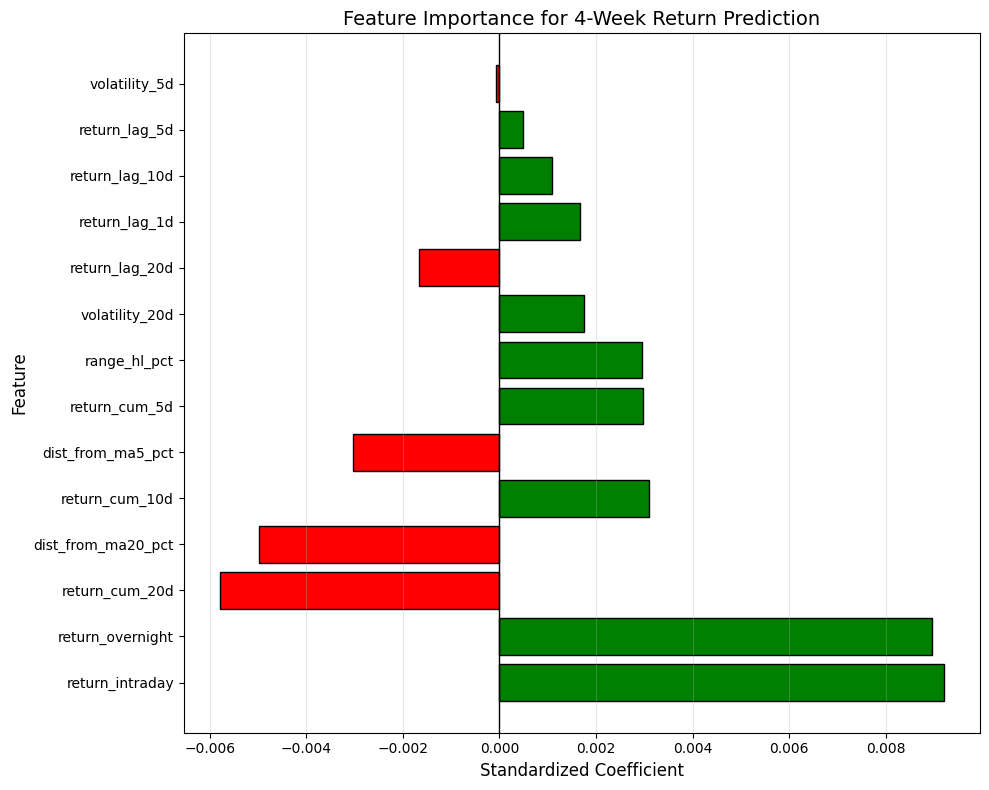


Top 5 Most Important Features:
               Feature  Coefficient
12     return_intraday       0.0092
13    return_overnight       0.0090
6       return_cum_20d      -0.0058
11  dist_from_ma20_pct      -0.0050
5       return_cum_10d       0.0031

💡 Interpretation:
   Green = Positive coefficient (higher feature → higher future return)
   Red   = Negative coefficient (higher feature → lower future return)
   Magnitude = Strength of relationship


In [30]:
# Analyze feature importance (from standardized coefficients)
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
colors = ['green' if x > 0 else 'red' for x in feature_importance['Coefficient']]
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors, edgecolor='black')
plt.xlabel('Standardized Coefficient', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Feature Importance for {HORIZON_NAME.title()} Return Prediction', fontsize=14)
plt.axvline(x=0, color='black', linewidth=1)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
print(feature_importance.head())

print("\n💡 Interpretation:")
print("   Green = Positive coefficient (higher feature → higher future return)")
print("   Red   = Negative coefficient (higher feature → lower future return)")
print("   Magnitude = Strength of relationship")

## Step 11: Visualize Predictions

> **Question**: Your model achieves R² = 0.03 and Hit Rate = 54% on stock prediction. A stakeholder calls it "worthless because R² is below 0.70." Your response?
>
> A. Agree - models below R² = 0.70 fail to meet quantitative finance industry standards
>
> B. Disagree - in noisy markets, R² = 0.03 is normal; 54% Hit Rate beats random and could profit
>
> C. Agree - low validation R² versus expected performance indicates severe overfitting problems
>
> D. Disagree - R² is meaningless for finance; only Hit Rate matters for trading profitability

<details><summary>Click to reveal answer</summary>

**Correct Answer: B**

**Explanation:**
- **B is TRUE**: Financial markets have extremely low signal-to-noise ratios. Professional quant funds often achieve R² = 0.01-0.10. The critical signal here is Hit Rate = 54% vs 50% random - a 4 percentage point edge. Consistently predicting direction correctly 54% of the time, with proper risk management, position sizing, and diversification, can generate significant profits. Many successful trading strategies operate in the 51-56% hit rate range.

- **A is FALSE**: There's no "R² = 0.70 industry standard" for financial prediction. That might apply to physics or engineering, but markets have too much random noise (news, sentiment, macro shocks). R² = 0.03 means you explain 3% of variance - small but meaningful in finance.

- **C is FALSE**: Low R² isn't evidence of overfitting - it's evidence of noisy data. Overfitting shows as HIGH training R² with LOW validation R². Here, both are low, which is expected in finance and suggests the model generalizes appropriately.

- **D is FALSE**: Both metrics provide value. R² tells you magnitude prediction accuracy (useful for portfolio optimization, position sizing). Hit Rate tells you directional accuracy (useful for long/short signals). Use both for complete evaluation.

**Key Insight**: In noisy domains, judge models by domain standards. A 4% edge over random (54% vs 50%) is more valuable than high R² on clean academic datasets!

</details>

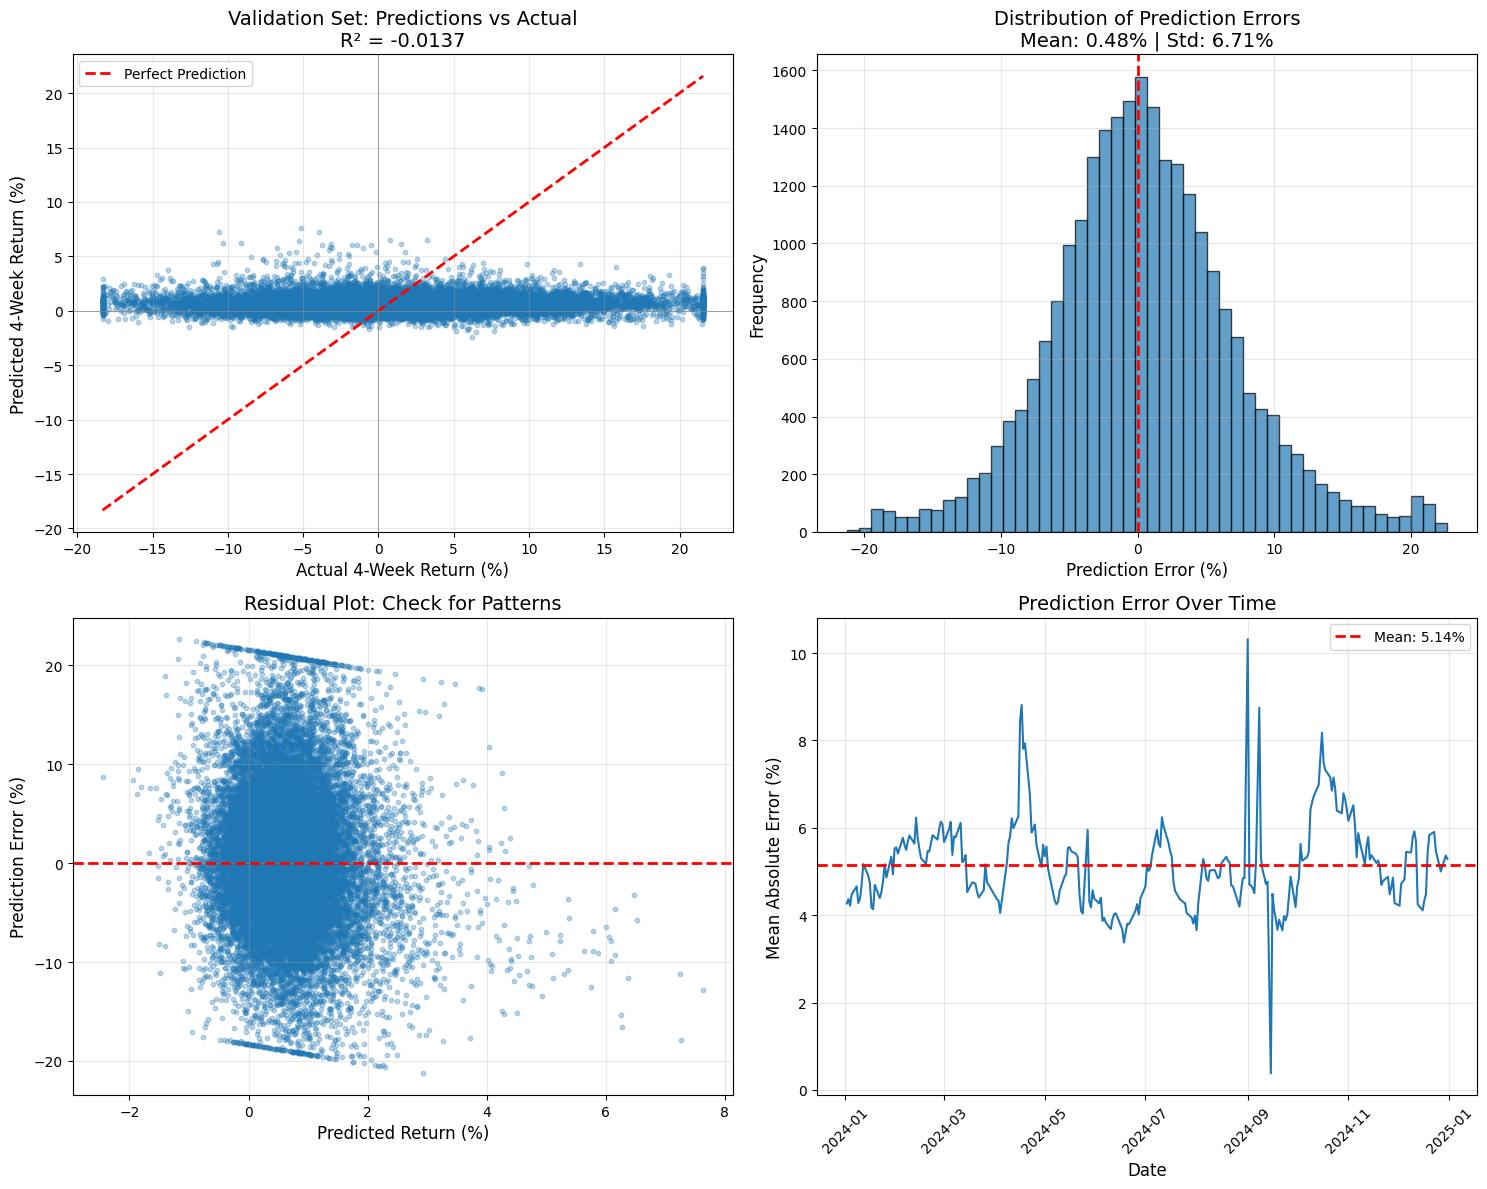

In [31]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Predicted vs Actual (Validation Set)
axes[0, 0].scatter(y_val * 100, y_val_pred * 100, alpha=0.3, s=10)
axes[0, 0].plot([y_val.min()*100, y_val.max()*100], [y_val.min()*100, y_val.max()*100],
               'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel(f'Actual {HORIZON_NAME.title()} Return (%)', fontsize=12)
axes[0, 0].set_ylabel(f'Predicted {HORIZON_NAME.title()} Return (%)', fontsize=12)
axes[0, 0].set_title(f'Validation Set: Predictions vs Actual\nR² = {val_metrics["r2"]:.4f}', fontsize=14)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(0, color='gray', linewidth=0.5)
axes[0, 0].axvline(0, color='gray', linewidth=0.5)

# Plot 2: Residual Distribution
residuals_val = (y_val - y_val_pred) * 100
axes[0, 1].hist(residuals_val, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Prediction Error (%)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title(f'Distribution of Prediction Errors\nMean: {residuals_val.mean():.2f}% | Std: {residuals_val.std():.2f}%', fontsize=14)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Error vs Predicted Return
axes[1, 0].scatter(y_val_pred * 100, residuals_val, alpha=0.3, s=10)
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Return (%)', fontsize=12)
axes[1, 0].set_ylabel('Prediction Error (%)', fontsize=12)
axes[1, 0].set_title('Residual Plot: Check for Patterns', fontsize=14)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Cumulative Error Over Time
val_df_copy = val_df.copy()
val_df_copy['predicted'] = y_val_pred
val_df_copy['error'] = np.abs(y_val - y_val_pred) * 100
error_by_date = val_df_copy.groupby('date')['error'].mean().sort_index()
axes[1, 1].plot(error_by_date.index, error_by_date.values, linewidth=1.5)
axes[1, 1].axhline(error_by_date.mean(), color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {error_by_date.mean():.2f}%')
axes[1, 1].set_xlabel('Date', fontsize=12)
axes[1, 1].set_ylabel('Mean Absolute Error (%)', fontsize=12)
axes[1, 1].set_title('Prediction Error Over Time', fontsize=14)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Step 12: Directional Accuracy (Trading Perspective)

### What is Directional Accuracy?

**Directional Accuracy = Hit Rate = Win Rate**

In trading terminology, these all mean the same thing:
- **What percentage of predictions correctly identified the direction?**
- If actual return is +5% and we predicted +2%, that's a **HIT** ✅ (both positive)
- If actual return is -3% and we predicted +1%, that's a **MISS** ❌ (wrong direction)

**Why it matters more than R² for trading:**

1. **Profitability depends on direction**:
   - If you predict stock will go UP → you BUY
   - If you predict stock will go DOWN → you SELL (or short)
   - The exact magnitude matters less than getting the direction right

2. **Baseline is 50%**:
   - Random guessing = 50% hit rate (coin flip)
   - 55% hit rate = consistently beating random (potentially profitable!)
   - 60%+ hit rate = very strong signal (professional quant level)

3. **Hit rate + Risk management = Strategy**:
   - Even 51% hit rate can be profitable with proper position sizing
   - Combined with stop losses and profit targets
   - Diversified across many stocks to reduce idiosyncratic risk

**Example:**
- Our model predicts 4-week returns for 1,000 stock-days
- 550 times we correctly predict UP or DOWN
- 450 times we get the direction wrong
- **Hit rate = 550 / 1,000 = 55%** ✅ Beats random!

This is what we calculate below: Can our linear regression model beat a 50% coin flip?


DIRECTIONAL ACCURACY / HIT RATE (Can we predict UP vs DOWN?)
Training:   53.82%
Validation: 54.39%
Test:       58.52%

Baseline (random guessing / coin flip): 50.00%
Our model beats random: True
Edge over random: +4.39 percentage points

💡 A 4.39% edge, when consistently applied with proper risk
   management across many trades, can be highly profitable!


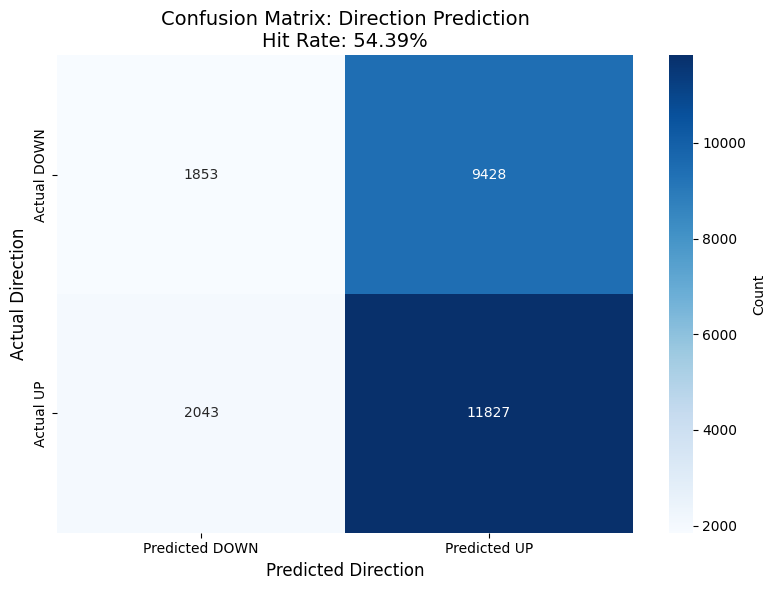


Classification Report (Direction):
              precision    recall  f1-score   support

        DOWN       0.48      0.16      0.24     11281
          UP       0.56      0.85      0.67     13870

    accuracy                           0.54     25151
   macro avg       0.52      0.51      0.46     25151
weighted avg       0.52      0.54      0.48     25151



In [32]:
# For trading, direction matters more than exact magnitude!
# Can we predict if stock will go UP or DOWN?

def directional_accuracy(y_true, y_pred):
    """
    Calculate what percentage of time we correctly predict direction.
    Also known as: Hit Rate, Win Rate
    """
    # Convert to up/down signals
    actual_direction = (y_true > 0).astype(int)  # 1 if up, 0 if down
    pred_direction = (y_pred > 0).astype(int)

    accuracy = (actual_direction == pred_direction).mean()

    return accuracy, actual_direction, pred_direction

# Calculate directional accuracy
train_dir_acc, _, _ = directional_accuracy(y_train, y_train_pred)
val_dir_acc, val_actual_dir, val_pred_dir = directional_accuracy(y_val, y_val_pred)
test_dir_acc, _, _ = directional_accuracy(y_test, y_test_pred)

print("\n" + "="*70)
print("DIRECTIONAL ACCURACY / HIT RATE (Can we predict UP vs DOWN?)")
print("="*70)
print(f"Training:   {train_dir_acc*100:.2f}%")
print(f"Validation: {val_dir_acc*100:.2f}%")
print(f"Test:       {test_dir_acc*100:.2f}%")
print("="*70)
print(f"\nBaseline (random guessing / coin flip): 50.00%")
print(f"Our model beats random: {val_dir_acc > 0.5}")

if val_dir_acc > 0.5:
    edge = (val_dir_acc - 0.5) * 100
    print(f"Edge over random: +{edge:.2f} percentage points")
    print(f"\n💡 A {edge:.2f}% edge, when consistently applied with proper risk")
    print(f"   management across many trades, can be highly profitable!")

# Confusion matrix for validation set
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(val_actual_dir, val_pred_dir)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted DOWN', 'Predicted UP'],
            yticklabels=['Actual DOWN', 'Actual UP'],
            cbar_kws={'label': 'Count'})
plt.ylabel('Actual Direction', fontsize=12)
plt.xlabel('Predicted Direction', fontsize=12)
plt.title(f'Confusion Matrix: Direction Prediction\nHit Rate: {val_dir_acc*100:.2f}%', fontsize=14)
plt.tight_layout()
plt.show()

print("\nClassification Report (Direction):")
print(classification_report(val_actual_dir, val_pred_dir,
                          target_names=['DOWN', 'UP']))

## Step 13: Case Study - Individual Stock Predictions

Selected tickers for visualization:
  1. LLOY.L: Avg price = 45p, Val data points = 254
  2. BA.L: Avg price = 947p, Val data points = 254
  3. AZN.L: Avg price = 9998p, Val data points = 254


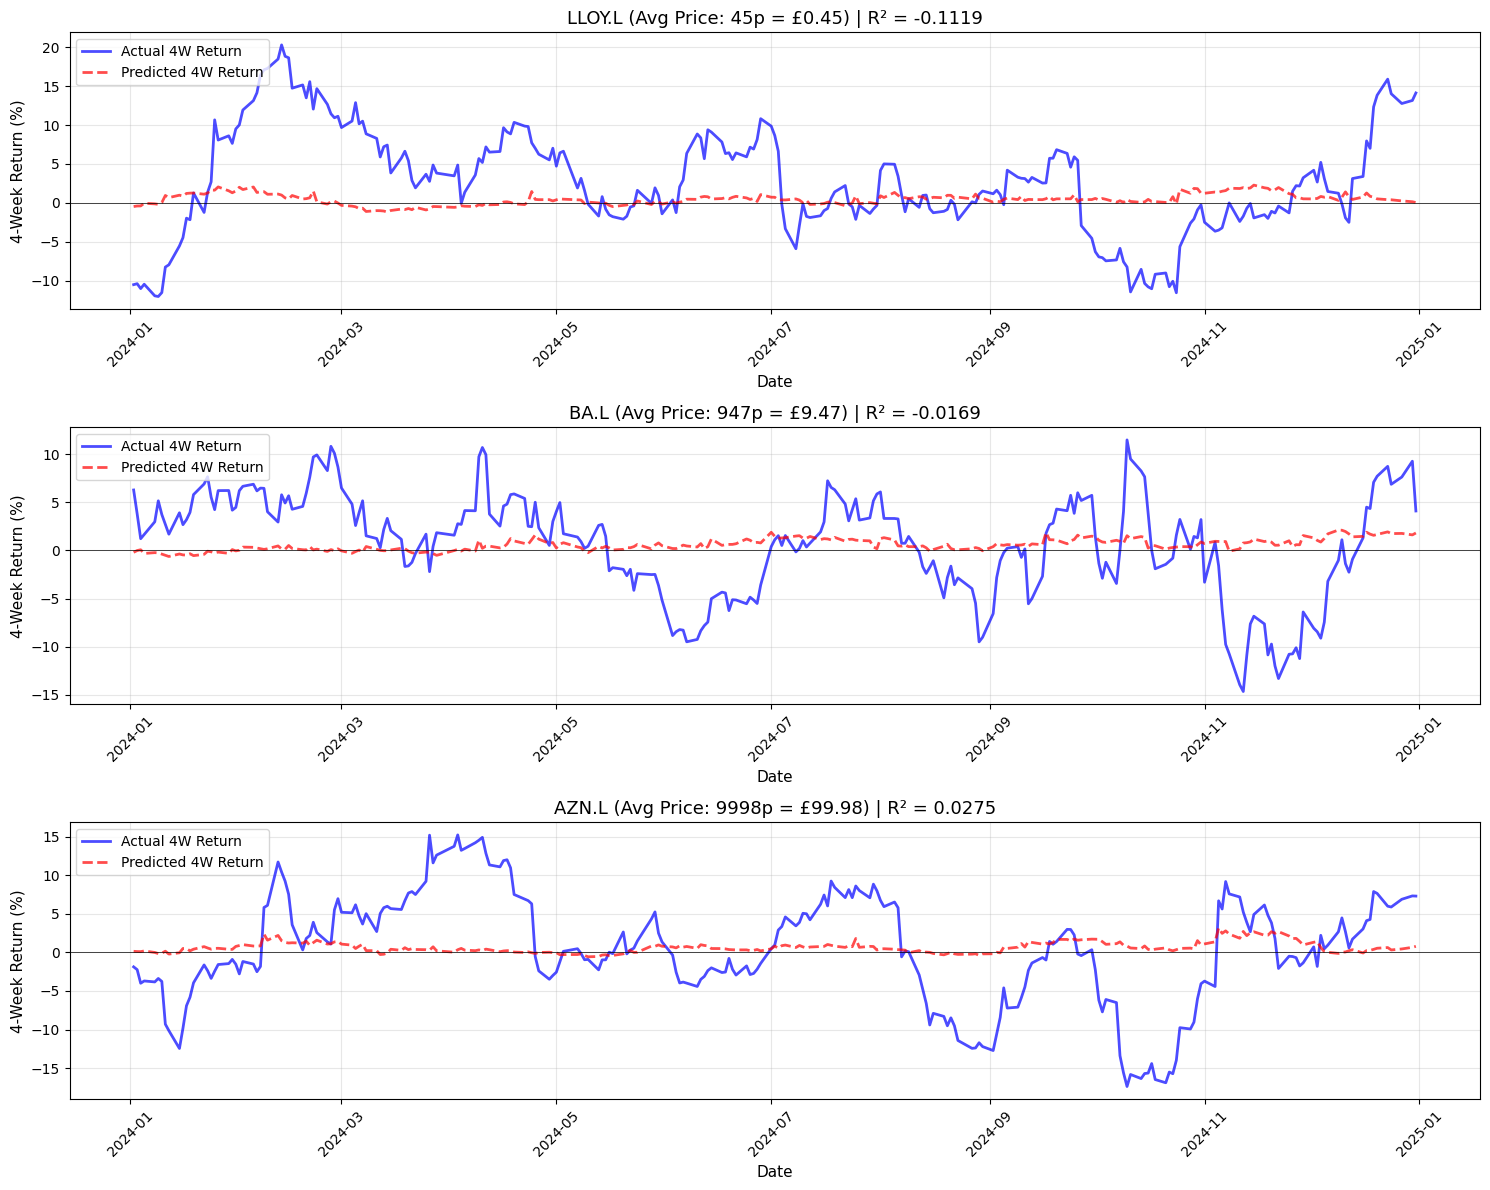


💡 Key Insight: The model works across ALL price levels!
   Returns normalize the different scales, enabling a unified model.


In [33]:
# Let's examine predictions for specific stocks
# Pick 3 stocks: cheap, medium, expensive (from CLEANED data that exists in val_df)

# IMPORTANT: Recalculate price stats from df_clean to ensure tickers still exist after cleaning
current_price_stats = df_clean.groupby('ticker')['adjclose'].agg(['min', 'mean', 'max', 'std']).sort_values('mean')

# Select tickers
sample_tickers = [
    current_price_stats.index[0],                           # Cheapest
    current_price_stats.index[len(current_price_stats)//2], # Medium
    current_price_stats.index[-1]                           # Most expensive
]

print("Selected tickers for visualization:")
for i, ticker in enumerate(sample_tickers):
    val_count = len(val_df[val_df['ticker'] == ticker])
    avg_price = current_price_stats.loc[ticker, 'mean']
    print(f"  {i+1}. {ticker}: Avg price = {avg_price:.0f}p, Val data points = {val_count}")

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

for idx, ticker in enumerate(sample_tickers):
    # Get validation data for this ticker
    ticker_mask = val_df['ticker'] == ticker
    ticker_val = val_df[ticker_mask].copy()

    if len(ticker_val) > 0:
        # CRITICAL FIX: Properly map y_val_pred positions to ticker data
        # val_df has its own index (from df_clean), but y_val_pred is sequential 0,1,2...
        # We need to find which positions in y_val correspond to this ticker

        # Create a position index
        val_df_with_position = val_df.reset_index(drop=True).reset_index()
        ticker_positions = val_df_with_position[val_df_with_position['ticker'] == ticker]['index'].values

        # Now get predictions for those positions
        ticker_val['predicted'] = y_val_pred[ticker_positions]

        # Plot actual vs predicted returns over time
        ax = axes[idx]
        ax.plot(ticker_val['date'], ticker_val['target_return_4w'] * 100,
               'b-', linewidth=2, label=f'Actual {HORIZON_NAME.upper()} Return', alpha=0.7)
        ax.plot(ticker_val['date'], ticker_val['predicted'] * 100,
               'r--', linewidth=2, label=f'Predicted {HORIZON_NAME.upper()} Return', alpha=0.7)
        ax.axhline(0, color='black', linewidth=0.5)
        ax.set_xlabel('Date', fontsize=11)
        ax.set_ylabel('4-Week Return (%)', fontsize=11)

        # Calculate R² for this ticker
        ticker_r2 = r2_score(ticker_val['target_return_4w'], ticker_val['predicted'])
        avg_price = current_price_stats.loc[ticker, 'mean']

        ax.set_title(f'{ticker} (Avg Price: {avg_price:.0f}p = £{avg_price/100:.2f}) | R² = {ticker_r2:.4f}', fontsize=13)
        ax.legend(loc='upper left')
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
    else:
        # No data for this ticker
        ax = axes[idx]
        ax.text(0.5, 0.5, f'No validation data for {ticker}\n(removed during data cleaning)',
               ha='center', va='center', fontsize=14, transform=ax.transAxes)
        ax.set_title(f'{ticker} - No Data', fontsize=13)

plt.tight_layout()
plt.show()

print("\n💡 Key Insight: The model works across ALL price levels!")
print("   Returns normalize the different scales, enabling a unified model.")

## Step 14: Understanding Model Limitations

### Why Stock Prediction is Hard (Even with ML)

Our model's R² is likely **low** (< 0.05). This is **normal** for stock prediction! Here's why:

#### 1. **Efficient Market Hypothesis (EMH)**
- Markets are highly efficient
- Past prices already incorporate all historical information
- If prediction were easy, everyone would do it and eliminate the opportunity

#### 2. **Noise-to-Signal Ratio**
Stock returns = Predictable signal + Random noise

$$r_t = \underbrace{\mu + \beta_1 x_1 + ... + \beta_n x_n}_{\text{Signal (tiny)}} + \underbrace{\epsilon_t}_{\text{Noise (huge)}}$$

The noise dominates! Even a "good" R² of 0.01 means your model explains 1% of variance.

#### 3. **Linear Regression Limitations**
- Assumes linear relationships (markets are non-linear)
- Can't capture regime changes (bull markets, crashes, volatility spikes)
- Ignores cross-stock interactions
- No consideration of external events (news, earnings, macro data)

#### 4. **What Professional Quants Do Differently**
- Use **hundreds of features** (alternative data, news sentiment, options flow)
- Employ **ensemble models** (Random Forests, Gradient Boosting, Neural Networks)
- Implement **regime detection** (separate models for different market conditions)
- Focus on **directional accuracy** and **risk-adjusted returns**, not R²
- Trade **many stocks** to diversify away idiosyncratic risk
- Operate at **higher frequencies** (daily, hourly, minute-level)

#### 5. **The Real Benchmark**
Even a **slight** edge (51% directional accuracy instead of 50%) can be profitable with:
- Proper risk management
- Position sizing
- Transaction cost optimization
- Portfolio diversification

## Key Takeaways

### ✅ What We Learned

1. **Scale Invariance is Critical**
   - Raw prices vary ~44x across stocks (68p to 3,000p, or £0.68 to £30)
   - Returns normalize this: both cheap and expensive stocks have ~2% daily volatility
   - Unified model trains on all stocks equally
   - **Important**: FTSE 100 prices are quoted in GBX (pence), not GBP (pounds)

2. **Time-Series Require Special Handling**
   - Never use random train/test splits (causes future data leakage)
   - Always split chronologically: train on past, test on future
   - Lagged features create dependencies that must be respected

3. **Domain Knowledge Matters**
   - Financial features (momentum, volatility, moving averages) are industry standard
   - Use meaningful lag intervals: 1, 5, 10, 20 days (not arbitrary 1,2,3,4,5)
   - Feature engineering dramatically improves over raw prices
   - Understanding the domain helps interpret model limitations

4. **Linear Regression for Finance**
   - **Strengths**: Fast, interpretable, works across all stocks
   - **Weaknesses**: Can't capture non-linearities, market regimes, or external shocks
   - **Reality**: Low R² is expected and doesn't mean failure

5. **Prediction vs Trading**
   - Directional accuracy matters more than exact values
   - Even 51% accuracy can be profitable with proper risk management
   - Real trading requires transaction costs, slippage, and position sizing

### 🚀 Extensions to Explore

1. **Better Models**: Try Ridge/Lasso regression, Random Forests, XGBoost
2. **More Features**: Add sector indicators, market-wide features, volatility indices
3. **Different Targets**: Predict volatility, drawdowns, or classification (up/down)
4. **Walk-Forward Analysis**: Retrain model periodically to adapt to changing markets
5. **Portfolio Optimization**: Use predictions to construct long/short portfolios

### 📚 Key Concepts Applied

| Concept | How We Used It |
|---------|---------------|
| **Linear Regression** | Unified model across 100 stocks |
| **Feature Engineering** | Percentage-based returns, lagged features (1,5,10,20 days), momentum, volatility |
| **Feature Scaling** | StandardScaler on all features |
| **Time-Series Split** | Chronological train/val/test |
| **Model Evaluation** | R², RMSE, MAE, directional accuracy |
| **Domain Knowledge** | Financial returns, trading metrics, GBX pricing |

### ⚠️ Important Warnings

**DO NOT** use this model for real trading without:
- Understanding market microstructure (bid-ask spreads, slippage)
- Implementing proper risk management (stop losses, position sizing)
- Accounting for transaction costs (commissions, taxes)
- Testing on more comprehensive data (multiple market cycles)
- Consulting with financial professionals

**This is for educational purposes only!**

## Summary

In this case study, we tackled a real-world financial ML problem:

1. ✅ Identified the **scale problem** with stock prices
2. ✅ Solved it using **percentage returns** instead of absolute prices
3. ✅ Engineered **domain-specific features** (momentum, volatility, moving averages)
4. ✅ Properly handled **time-series data** (chronological splits, no lookahead bias)
5. ✅ Built a **unified linear regression model** for 100 different stocks
6. ✅ Evaluated with **financial metrics** (directional accuracy, risk-adjusted performance)
7. ✅ Understood **model limitations** and real-world challenges

**Most importantly**: We learned that **feature engineering and domain knowledge matter more than algorithm complexity** in many real-world problems!

Linear Regression, while simple, taught us:
- The importance of proper data transformation
- How to handle multi-entity datasets
- Why time-series require special treatment
- That "low R²" doesn't mean "bad model" in noisy domains

These lessons apply far beyond stock prediction - to demand forecasting, sensor data, medical time series, and more!

---

## 🚀 What's Next? Extensions & Advanced Topics

### 📈 Immediate Improvements (Low-Hanging Fruit)

1. **Regularization** (Ridge/Lasso)
   ```python
   from sklearn.linear_model import Ridge, Lasso
   # Prevents overfitting by penalizing large coefficients
   ridge_model = Ridge(alpha=1.0)  # L2 regularization
   lasso_model = Lasso(alpha=0.1)  # L1 regularization + feature selection
   ```
   **Why**: Handles multicollinearity and reduces overfitting

2. **Polynomial Features**
   ```python
   from sklearn.preprocessing import PolynomialFeatures
   # Capture non-linear relationships
   poly = PolynomialFeatures(degree=2, include_bias=False)
   X_poly = poly.fit_transform(X_train_scaled)
   ```
   **Why**: Markets aren't perfectly linear!

3. **Cross-Validation** (Time-Series Specific)
   ```python
   from sklearn.model_selection import TimeSeriesSplit
   # Proper validation for time-series data
   tscv = TimeSeriesSplit(n_splits=5)
   for train_idx, val_idx in tscv.split(X):
       # Train on past, validate on future (multiple times)
   ```
   **Why**: More robust performance estimates

### 🎯 Advanced Modeling

4. **Ensemble Methods**
   - **Random Forest**: Captures non-linearities, feature interactions
   - **XGBoost/LightGBM**: State-of-the-art for tabular data
   - **Stacking**: Combine multiple model predictions

5. **Feature Engineering 2.0**
   - Sector indicators (one-hot encode industry)
   - Market-wide features (VIX volatility index, market returns)
   - Cross-stock features (correlation with sector, relative strength)
   - Fundamental data (P/E ratios, earnings)
   - Alternative data (news sentiment, social media)

6. **Different Prediction Targets**
   - **Classification**: UP/DOWN binary (better for trading signals)
   - **Volatility prediction**: Predict risk, not returns
   - **Probability distributions**: Quantile regression

### 🔬 Production-Ready Enhancements

7. **Walk-Forward Analysis**
   ```
   Train on 2019-2020 → Test on 2021
   Train on 2019-2021 → Test on 2022
   Train on 2019-2022 → Test on 2023
   ...
   ```
   **Why**: Markets change! Retrain periodically

8. **Transaction Cost Modeling**
   - Bid-ask spreads
   - Commissions
   - Market impact (your trades move prices!)
   - Realistic profit/loss calculation

9. **Risk Management**
   - Position sizing (Kelly criterion)
   - Stop losses
   - Portfolio diversification
   - Max drawdown constraints

### 💡 Research Directions

10. **Regime Detection**
    - Separate models for bull/bear/sideways markets
    - Use Hidden Markov Models or changepoint detection
    - Adapt strategy to market conditions

11. **Meta-Labeling**
    - First model: Predict magnitude
    - Second model: Predict if first model is confident enough to trade
    - Reduces false positives

12. **Portfolio Optimization**
    - Use predictions to construct optimal portfolios
    - Mean-variance optimization
    - Risk parity
    - Long/short strategies

### 📚 Recommended Learning Path

**If you're new to finance ML:**
1. Study this notebook thoroughly
2. Try Ridge/Lasso regularization
3. Experiment with different features
4. Read "Advances in Financial Machine Learning" by Marcos López de Prado

**If you're experienced:**
1. Implement walk-forward validation
2. Build ensemble models
3. Add transaction costs and risk management
4. Research regime detection

### ⚠️ Final Reminder

Remember: This is **educational**. Real quantitative trading requires:
- Deep understanding of markets and microstructure
- Rigorous backtesting with realistic assumptions
- Risk management systems
- Regulatory compliance
- Continuous monitoring and adaptation

**But** the skills you learned here - domain knowledge, feature engineering, proper evaluation - apply to *any* time-series prediction problem!

---

**Want to explore more?**
- Check other case studies in this repository
- Try applying these techniques to your own time-series data
- Join online communities (Quantitative Finance Stack Exchange, r/algotrading)

**Happy modeling!** 🎉